# 用未标记数据进行预训练

## 前置

### 初始化 GPT 模型

#### 代码 - GPTModel

In [1]:
# 使用第四章实现的 GPT 模型 

import torch
import sys
sys.path.append('./src')

from src.GPTModel import GPTModel

GPT_CONFIG_124M = {
"vocab_size": 50257,
"context_length": 256, # 阉割版，标准为1024
"emb_dim": 768,
"n_heads": 12,
"n_layers": 12,
"drop_rate": 0.1,
"qkv_bias": False
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (relu): GELU(approximate='none')
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop_resid): Dropout(p=0.1, i

#### 文本和token之间的转换

In [2]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # 添加批次维度
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # 消除批次维度
    return tokenizer.decode(flat.tolist())

##### 代码 - generate_text_simple

In [3]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # 当前上下文的索引数组 idx，要生成的新token的最大数量 max_new_tokens
    for _ in range(max_new_tokens):
        # 使用最后上下文大小的索引数组
        idx_cond = idx[:, -context_size:]
        
        # 调用模型
        with torch.no_grad():
            logits = model(idx_cond)
        # 将 (batch, n_token, vocab_size) 转换为 (batch, vocab_size)
        logits = logits[:, -1, :]
        # 获取具有最高logits值的词汇表条目的索引
        idx_next = torch.argmax(logits, dim=-1, keepdim=True) # 形状为 (batch, 1)
        # 将采样的索引追加到运行序列
        idx = torch.cat((idx, idx_next), dim=1) # 形状为 (batch, n_tokens+1)
    return idx

###### 测试

In [4]:
import tiktoken

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


显然模型还无法生成连贯文本，因未经过训练。需要引入模型评估指标

## Training loop

### 步骤

#### 示意图
![image.png](https://gitee.com/rees-matthew/picture-bed/raw/master/picgo//202408182148978.png)

对于每个训练epoch，每个训练batch
3）重置先前epoch损失梯度，

4）计算当前batch的损失，

5）反向传播计算损失梯度，

6）使用损失梯度更新模型权重

打印训练验证集损失，生成样例文本可视化监控

## Model evaluation

### 计算文本生成损失

#### 引入

示意图：
![image.png](https://gitee.com/rees-matthew/picture-bed/raw/master/picgo//202408171017122.png)

In [5]:
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
                       [40, 1107, 588]]) # "I really like"]

targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
                        [588, 428, 11311]]) # " really like chocolate"]

# 上图步骤3
with torch.no_grad(): 
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1) # 词表中每个 token 的概率
print(probas.shape)

# 上图步骤4
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

# 上图步骤5
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

torch.Size([2, 3, 50257])
Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [6]:
# 打印目标token与对应初始softmax的概率分布

text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4537e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([3.9834e-05, 1.6783e-05, 4.7559e-06])


* LLM 的训练目标就是最大化这些概率值。

#### 反向传播

* 更新模型的权重，使得模型对我们希望生成的各个token ID 输出更高的值。
* 需要一个*损失函数*，用于计算模型预测输出与实际期望输出之间的差距。
    * 衡量模型预测结果与目标值之间的偏离程度 

##### 计算损失

示意图
![image.png](https://gitee.com/rees-matthew/picture-bed/raw/master/picgo//202408171540590.png)

* 步骤
    1. 进行一次 traning loop ，计算每个输入token的 logits 矫正值（维度：`[2, 3, 50257]`，下同。即每个词汇为对应输出的矫正值）
    2. 使用[[深度学习概念#Softmax函数|softmax函数]]将 logits 转换为 probabilitites （`[2, 3, 50257]`)
    3. 对每个输入 token 取最大 probabilitites 作为 target probabilities （`[6]`)
    4. 对 target probabilities 取对数，得 log probabilitites（`[6]`)
    5. log probabilitites 求和得 average log probability (`[1]`)
    6. 取负得到 negative average log probability (`[1]`)

In [7]:
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
                       [40, 1107, 588]]) # "I really like"]
targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
                        [588, 428, 11311]]) # " really like chocolate"]

# 步骤1: 获得 logits
with torch.no_grad(): 
    logits = model(inputs)
    
# 步骤2: 
probas = torch.softmax(logits, dim=-1) # 词表中每个 token 的概率
print(probas.shape)

# 步骤3: 对每个输入 token 取最大 probabilitites 作为 target probabilities
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
target_probas_1 = probas[0, [0, 1, 2], targets[text_idx]]
target_probas_2 = probas[1, [0, 1, 2], targets[text_idx]]

# 步骤4：对概率分数应用对数函数
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

# 步骤5：计算平均值将对数概率合并为一个分数
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

# 步骤6：取得负数
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

torch.Size([2, 3, 50257])
tensor([-11.6553, -10.8378, -11.8961, -10.1308, -10.9951, -12.2561])
tensor(-11.2952)
tensor(11.2952)


下面使用 pytorch 的 cross_entropy来实现

In [8]:
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
                       [40, 1107, 588]]) # "I really like"]
targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
                        [588, 428, 11311]]) # " really like chocolate"]

# 步骤1: 获得 logits
with torch.no_grad(): 
    logits = model(inputs)

# 铺平
logits_flat = logits.flatten(0, 1) # [6, 50257]
targets_flat = targets.flatten() # [6]

loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)


tensor(10.7723)


### 计算训练集和验证集损失

In [9]:
# 使用 the-verdic.txt 数据集

file_path = "./input/the-verdict.txt"
with open(file_path, 'r', encoding="utf-8") as file:
    text_data = file.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


#### 准备数据加载器

exp：

![image.png](https://gitee.com/rees-matthew/picture-bed/raw/master/picgo//202408182052545.png)

1. 先将输入文本分割为训练集和验证集；
2. 对文本进行 token 化处理，并将token化后的文本划分为用户指定长度块
3. 打乱各行顺序，并划分batch
4. 进行模型训练

##### 划分训练验证集

In [12]:
# 定义一个train_ration
train_ration = 0.90
split_idx = int(train_ration * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

# 复用之前的数据加载器
sys.path.append('./src')
from src.GPTDataset import create_dataloader_v1

torch.manual_seed(123)
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False
)


# 遍历测试

print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)
    
print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


##### 计算交叉熵损失

In [17]:
# 计算单批次的损失函数
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device) #A
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1),
        target_batch.flatten()
    )
    return loss

###### 代码 - 计算损失函数

In [18]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [19]:
# 测试：

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_loss = calc_loss_loader(train_loader, model, device)
val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758167690701
Validation loss: 10.98110580444336


## Load pretrained weights

### 代码 - 预训练 LLM

In [24]:

# 计算训练和验证集的损失，同时确保模型处于评估模式
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches = eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches = eval_iter)
    model.train()
    return train_loss, val_loss

# 生成文本示例
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model = model, idx = encoded,
            max_new_tokens = 50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))
    model.train()
        
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        generate_and_print_sample(
            model, train_loader.dataset.tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen       

### 训练
通过 AdamW优化器，和我们之前定义的 train_model_simple 训练10个epoch

In [25]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1) #A
num_epochs = 10
train_losses, val_losses, track_tokens_seen =  train_model_simple(
    model, train_loader, val_loader, optimizer, device, 
    num_epochs=num_epochs, eval_freq=5, eval_iter=1,
    start_context="Every effort moves you"
)


Ep 1 (Step 000000): Train loss 9.946, Val loss 9.939
Ep 1 (Step 000005): Train loss 7.644, Val loss 8.336
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 7.045, Val loss 7.058
Ep 2 (Step 000015): Train loss 5.765, Val loss 6.607
Every effort moves you, and, and, and, and, and, and, and, and,, and,, and, and, and, and, and, and, and,, and, and,, and, and,, and,, and
Ep 3 (Step 000020): Train loss 8.869, Val loss 9.147
Ep 3 (Step 000025): Train loss 5.589, Val loss 6.509
Every effort moves you, and I had to the to the to the to the and.                                    
Ep 4 (Step 000030): Train loss 5.295, Val loss 6.484
Ep 4 (Step 000035): Train loss 4.969, Val loss 6.460
Every effort moves you, and he had been the of the of the theis theis the of the of theis, and the   "I theis the of the of the of theis theis the of the picture the of the", and
Ep 5 (Step 000040): Train loss 3.805, Val loss 6.417
Every effort moves you.      

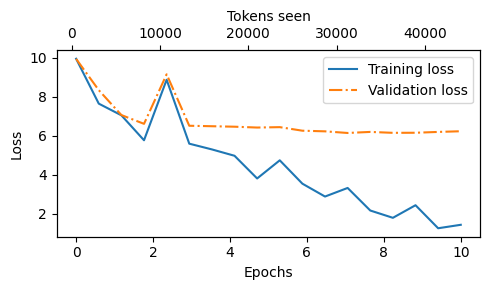

In [26]:
# 绘制训练集和验证集损失

import matplotlib.pyplot as plt
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax2 = ax1.twiny() #A
    ax2.plot(tokens_seen, train_losses, alpha=0) #B
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, track_tokens_seen, train_losses, val_losses)